<a href="https://colab.research.google.com/github/gegretel/AML7/blob/master/Project7_RNN_Team2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project 7 - Team 2**

Joe, Getong, Abby 

In this exercise, you are to work in your previous group on stock market forecast. Collect performance data for a period of 12 months for a favorite stock (Apple, Google, etc.) and perform the following tasks:

1) Use the most accurate model (LSTM or GRU)  that best predicts the collected data pertaining to the past 12 months. Pay special attention to the selected #units, activation functions, dropouts, dense layer configuration, etc.

2) Use your model from part 1 to make predictions for the next month, next 5 months, and the next 10 months. 

3) Make sure to plot your results in both parts 1 and 2.

4) Fully discuss and justify your results.


# **Introduction**
Technical indicators are available at large numbers and used mostly by stock traders. Most indicators have user-defined variables which allow traders to adapt key inputs such as look-back period which tell us how much historical data will be used to form the calculations to suit their needs. We will use some of the indicators to create features in the existing data set. Applying these features, we will see if we can predict the future price of a particular stock.

We will use Gated Recurrent Unit (GRU) and Long Short-Term Memory (LSTM) of recurrent units to compare their performance. LSTM is well established on sequence-based tasks with long-term dependencies, and GRU is a new addition in the field of machine learning which is an improvised version of Recurrent Neural Network(RNN). 

We use LSTM and GRU to predict the collected data pertaining to the past 12 months first. Then we use this model to make predictions for the next month, next 5 months, and the next 10 months. Finally we compared the results at the end of this project.


#**Part I: RNN/LSTM/GRU**

We have collected stock performance data for a period of 5 years (2015-2020)for Apple, and performed the following tasks:

# Setup

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [0]:
# Download the data
import urllib
import os
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/fsclsnow/AML/master/"
AP_PATH = os.path.join("Data")
AP_URL = DOWNLOAD_ROOT + "Data/AAPL_2015-2020.csv"

In [0]:
import pandas as pd
def load_ap_data(ap_path=AP_PATH):
    csv_path = os.path.join(DOWNLOAD_ROOT, ap_path, "AAPL_2015-2020.csv")
    return pd.read_csv(csv_path)

#Prepare the Data 

In [0]:
ap5 = load_ap_data()
real_price = ap5.filter(['Open'])
ap5.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-04-27,132.309998,133.130005,131.149994,132.649994,122.072395,96954200
1,2015-04-28,134.460007,134.539993,129.570007,130.559998,120.149078,118924000
2,2015-04-29,130.160004,131.589996,128.300003,128.639999,118.382187,63386100
3,2015-04-30,128.639999,128.639999,124.580002,125.150002,115.170479,83195400
4,2015-05-01,126.099998,130.130005,125.300003,128.949997,118.667458,58512600


In [0]:
print("checking if any null values are present\n", ap5.isna().sum())

checking if any null values are present
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


We do not have any missing values in this dataset. 

In [0]:
ap5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


Above info() method showed us that there are 1259 instances in the dataset, while all of them have non-null values. 

All attributes are numberical —— stock prices each day (high, low, open, close) and stock volume —— except the Date attribute, which is Object type. Now let's see how does it look on a plot:

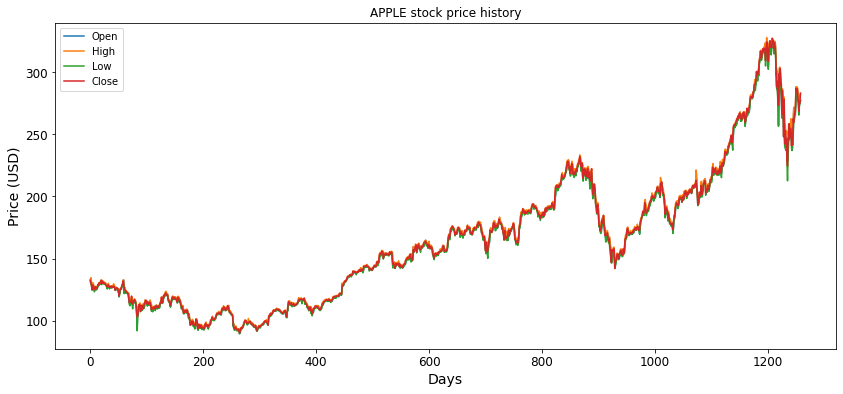

In [0]:
from matplotlib import pyplot as plt
plt.figure(figsize=(14, 6))
plt.plot(ap5["Open"])
plt.plot(ap5["High"])
plt.plot(ap5["Low"])
plt.plot(ap5["Close"])
plt.title('APPLE stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

Seems like the stock prices (open, close, high, low) don't vary too much. 

Let's take a look at the stock volume:

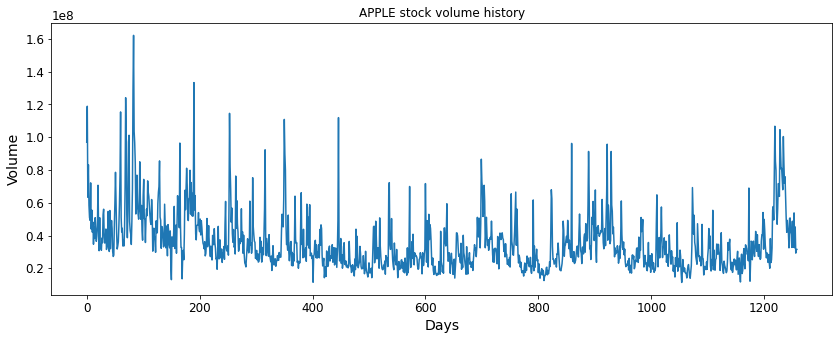

In [0]:
plt.figure(figsize=(14, 5))
plt.plot(ap5["Volume"])
plt.title('APPLE stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

Interesting! Seems like the number of transcations would surge every once a while. 

**Perform feature scaling by normalizing the data**

In [0]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled = sc.fit_transform(ap5.iloc[:,1:2])

In [0]:
training_set_scaled.shape

(1259, 1)

In [0]:
X_train = []
Y_train = []
previous = 60
for i in range(previous,len(training_set_scaled)):
  X_train.append(training_set_scaled[i-previous:i,0])
  Y_train.append(training_set_scaled[i,0])

X_train, Y_train = np.array(X_train)[:], np.array(Y_train)[:]
x_train, y_train = np.array(X_train)[:len(X_train)-365], np.array(Y_train)[:len(Y_train)-365]
x_valid, y_valid = np.array(X_train)[len(X_train)-365-previous:len(X_train)-60], np.array(Y_train)[len(Y_train)-365-previous:len(Y_train)-60]
# x_test, y_test = np.array(X_train)[len(X_train)-60-previous:], np.array(Y_train)[len(Y_train)-60-previous:]

x_1m, y_1m = np.array(X_train)[len(X_train)-365-previous:len(X_train)-335], np.array(Y_train)[len(Y_train)-365-previous:len(Y_train)-335]
x_4m, y_4m = np.array(X_train)[len(X_train)-365-previous:len(X_train)-245], np.array(Y_train)[len(Y_train)-365-previous:len(Y_train)-245]

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_valid = np.reshape(x_valid, (x_valid.shape[0],x_valid.shape[1],1))
# x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
x_1m = np.reshape(x_1m, (x_1m.shape[0],x_1m.shape[1],1))
x_4m = np.reshape(x_4m, (x_4m.shape[0],x_4m.shape[1],1))


Training Set     previous 4 years

Validation Set   last year without last 60 days (10 months after the training set)

Test Set         last 60days

x_1m             1 month after training set (30days)

x_4m             4 month after training set (120 days)

In [0]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout

Using TensorFlow backend.


Initialising the RNN

Building the LSTM layers and some Dropout regularization

In [0]:
modelLSTM = Sequential()

In [0]:
# Adding the first LSTM layer and some Dropout regularisation
modelLSTM.add(LSTM(units = 50, return_sequences= True, input_shape = (x_train.shape[1],1)))
modelLSTM.add(Dropout(0.2))

In [0]:
# Adding a second LSTM layer and some Dropout regularisation
modelLSTM.add(LSTM(units = 50, return_sequences= True))
modelLSTM.add(Dropout(0.2))

In [0]:
# Adding a third LSTM layer and some Dropout regularisation
modelLSTM.add(LSTM(units = 50, return_sequences= True))
modelLSTM.add(Dropout(0.2))

In [0]:
# Adding a fouth LSTM layer and some Dropout regularisation
modelLSTM.add(LSTM(units = 50))
modelLSTM.add(Dropout(0.2))

In [0]:
# Adding the output layer
modelLSTM.add(Dense(1,activation='tanh'))

In [0]:
# Compiling the RNN
modelLSTM.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [0]:
# Fitting the RNN to the Training set
history = modelLSTM.fit(X_train, Y_train, epochs = 50, batch_size = 32, validation_data=(x_valid, y_valid))

Train on 1199 samples, validate on 365 samples
Epoch 1/50
1199/1199 [==============================] - 7s 6ms/step - loss: 0.0251 - val_loss: 0.0109
Epoch 2/50
1199/1199 [==============================] - 6s 5ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 3/50
1199/1199 [==============================] - 5s 5ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 4/50
1199/1199 [==============================] - 5s 5ms/step - loss: 0.0034 - val_loss: 0.0039
Epoch 5/50
1199/1199 [==============================] - 6s 5ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 6/50
1199/1199 [==============================] - 6s 5ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 7/50
1199/1199 [==============================] - 6s 5ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 8/50
1199/1199 [==============================] - 6s 5ms/step - loss: 0.0022 - val_loss: 0.0039
Epoch 9/50
1199/1199 [==============================] - 6s 5ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 10/50
1199/1199 [============

In [0]:
modelLSTM.evaluate(X_train, Y_train)

1199/1199 [==============================] - 1s 892us/step


0.0005797405708371486

In [0]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 50, 0, 0.01])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

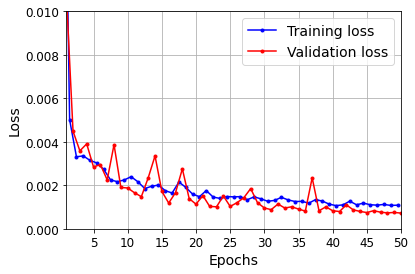

In [0]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

* If validation loss > training loss you can call it some overfitting. 
* If validation loss < training loss you can call it some underfitting.

Here we can see validation Loss is a little bit lower than training loss, thus LMTS model is a little bit underfitting. But not bad at all.  




Building the GRU layers and some Dropout regularization

In [0]:
# The GRU architecture
modelGRU = Sequential()
# First GRU layer with Dropout regularisation
modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
modelGRU.add(Dropout(0.2))
# Second GRU layer
modelGRU.add(GRU(units=50, return_sequences=True))
modelGRU.add(Dropout(0.2))
# Third GRU layer
modelGRU.add(GRU(units=50, return_sequences=True))
modelGRU.add(Dropout(0.2))
# Fourth GRU layer
modelGRU.add(GRU(units=50))
modelGRU.add(Dropout(0.2))
# The output layer
modelGRU.add(Dense(1,activation='tanh'))

# Compiling the RNN
modelGRU.compile(optimizer='adam',loss='mean_squared_error', metrics=['accuracy'])


In [0]:
# Fitting to the training set
history2 = modelGRU.fit(X_train, Y_train, epochs = 50, batch_size = 32, validation_data=(x_valid, y_valid))

Train on 1199 samples, validate on 365 samples
Epoch 1/50
1199/1199 [==============================] - 8s 7ms/step - loss: 0.0261 - accuracy: 0.0017 - val_loss: 0.0028 - val_accuracy: 0.0000e+00
Epoch 2/50
1199/1199 [==============================] - 6s 5ms/step - loss: 0.0041 - accuracy: 0.0017 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 3/50
1199/1199 [==============================] - 6s 5ms/step - loss: 0.0029 - accuracy: 0.0017 - val_loss: 0.0024 - val_accuracy: 0.0000e+00
Epoch 4/50
1199/1199 [==============================] - 6s 5ms/step - loss: 0.0028 - accuracy: 0.0017 - val_loss: 0.0023 - val_accuracy: 0.0000e+00
Epoch 5/50
1199/1199 [==============================] - 6s 5ms/step - loss: 0.0024 - accuracy: 0.0017 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 6/50
1199/1199 [==============================] - 6s 5ms/step - loss: 0.0021 - accuracy: 0.0017 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 7/50
1199/1199 [==============================] - 6s 5ms/st

In [0]:
modelGRU.evaluate(X_train, Y_train)

1199/1199 [==============================] - 1s 838us/step


[0.00047748152429146303, 0.0016680567059665918]

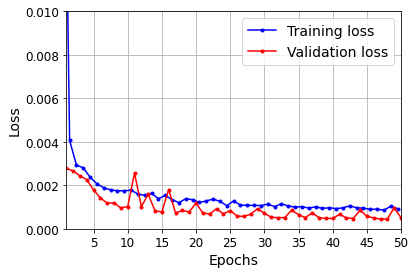

In [0]:
plot_learning_curves(history2.history["loss"], history2.history["val_loss"])
plt.show()

Here we can see validation Loss is also somewhat lower than training loss, GRU model is somewhat underfitting as well, and a bit better than LSTM model. 

# Using LSTM model to predict
Here we use **Open** stock price to make the predictions.

In [0]:
# Getting the real stock price
dataset_test = load_ap_data()
dataset_test = dataset_test[:len(dataset_test)]
real_stock_price = dataset_test.iloc[previous:len(dataset_test),1:2].values

In [0]:
dataset_total = pd.concat((ap5['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - previous:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)
x_test = []
for i in range (previous,len(dataset_test)):
  x_test.append(inputs[i-previous:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predicted_stock_price_LSTM = modelLSTM.predict(x_test)
predicted_stock_price_LSTM = sc.inverse_transform(predicted_stock_price_LSTM)

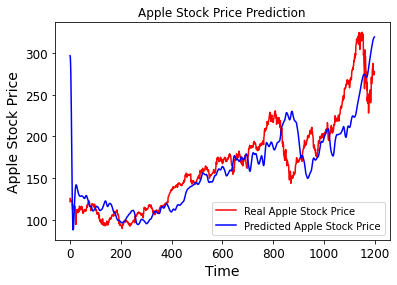

In [0]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Apple Stock Price')
plt.plot(predicted_stock_price_LSTM, color = 'blue', label = 'Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

As we can see in this prediction plot, the trends of the predicted and real prices are pretty much the same. The lines has the same peaks and troughs. This is probably because of LSTM's ability to remember sequenced data. A traditional feedforward neural networks would not have been able to forecast this result. This is the true power of LSTM and RNNs. 

In [0]:
# Get the root mean squared error (RMSE)
rmse_LSTM = np.sqrt(np.mean(((predicted_stock_price_LSTM - real_stock_price) ** 2)))
rmse_LSTM

29.256325177926364

# Using GRU model to predict

In [0]:
dataset_total = pd.concat((ap5['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - previous:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)
x_test = []
for i in range (previous,len(dataset_test)):
  x_test.append(inputs[i-previous:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predicted_stock_price_GRU = modelGRU.predict(x_test)
predicted_stock_price_GRU = sc.inverse_transform(predicted_stock_price_GRU)

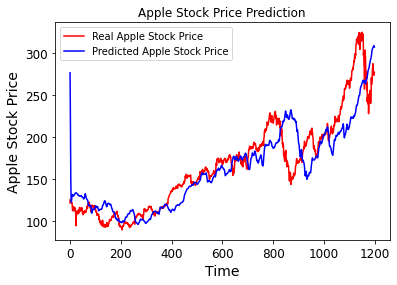

In [0]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Apple Stock Price')
plt.plot(predicted_stock_price_GRU, color = 'blue', label = 'Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

As we can see in this GRU plot, the trends of the predicted and real prices are pretty much the same as well, not too much different as the LSTM model: the lines still has the same peaks and troughs. 

In [0]:
# Get the root mean squared error (RMSE)
rmse_GRU = np.sqrt(np.mean(((predicted_stock_price_GRU - real_stock_price) ** 2)))
rmse_GRU

26.657425779439954

# Forecasting 30 steps ahead (One Month)

In [0]:
n_steps = 30
dataset_test = load_ap_data()
dataset_1m = dataset_test[len(dataset_test)-365-previous:len(dataset_test)-365 + n_steps]
real_stock_price_1m = dataset_1m.iloc[:,1:2].values

real_price_1m = real_price[len(dataset_test)-365-previous:len(dataset_test)-365 + n_steps]
train_1m = real_price_1m[:previous]
valid_1m = real_price_1m[previous:]


In [0]:
dataset_to = pd.concat((ap5['Open'], dataset_1m['Open']), axis = 0)
inputs = dataset_to[len(dataset_to) - len(dataset_1m) - previous:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)
x_test = []
for i in range (previous,len(dataset_1m)):
  x_test.append(inputs[i-previous:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [0]:
predicted_stock_price_1m = modelLSTM.predict(x_test)
predicted_stock_price_1m = sc.inverse_transform(predicted_stock_price_1m)

In [0]:
# Get the root mean squared error (RMSE)
valid_value = valid_1m.values
rmse_1m = np.sqrt(np.mean(((predicted_stock_price_1m - valid_value) ** 2)))
rmse_1m

61.66424622058943

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


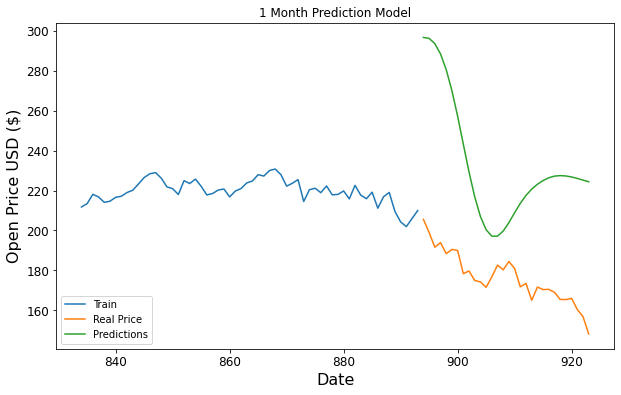

In [0]:
valid_1m['Predictions'] = predicted_stock_price_1m
# Visualize the data
plt.figure(figsize=(10,6))
plt.title('1 Month Prediction Model')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Open Price USD ($)', fontsize=16)
plt.plot(train_1m['Open'])
plt.plot(valid_1m[['Open', 'Predictions']])
plt.legend(['Train', 'Real Price', 'Predictions'], loc='lower left')
plt.show()

# Forecasting 120 steps ahead (Four Month)

In [0]:
n_steps = 120
dataset_test = load_ap_data()
dataset_4m = dataset_test[len(dataset_test)-365-previous:len(dataset_test)-365 + n_steps]
real_stock_price_4m = dataset_1m.iloc[:,1:2].values

real_price_4m = real_price[len(dataset_test)-365-previous:len(dataset_test)-365 + n_steps]
train_4m = real_price_4m[:previous]
valid_4m = real_price_4m[previous:]

In [0]:
dataset_to = pd.concat((ap5['Open'], dataset_4m['Open']), axis = 0)
inputs = dataset_to[len(dataset_to) - len(dataset_4m) - previous:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)
x_test = []
for i in range (previous,len(dataset_4m)):
  x_test.append(inputs[i-previous:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predicted_stock_price_4m = modelLSTM.predict(x_test)
predicted_stock_price_4m = sc.inverse_transform(predicted_stock_price_4m)

In [0]:
# Get the root mean squared error (RMSE)
valid_value = valid_4m.values
rmse_4m = np.sqrt(np.mean(((predicted_stock_price_4m - valid_value) ** 2)))
rmse_4m

51.71575177624989

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


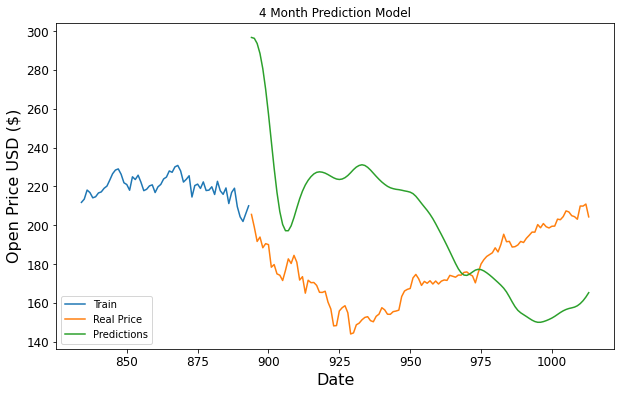

In [0]:
valid_4m['Predictions'] = predicted_stock_price_4m
# Visualize the data
plt.figure(figsize=(10,6))
plt.title('4 Month Prediction Model')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Open Price USD ($)', fontsize=16)
plt.plot(train_4m['Open'])
plt.plot(valid_4m[['Open', 'Predictions']])
plt.legend(['Train', 'Real Price', 'Predictions'], loc='lower left')
plt.show()

# Forecasting 335 steps ahead (Ten Month)

In [0]:
n_steps = 335
dataset_test = load_ap_data()
dataset_10m = dataset_test[len(dataset_test)-365-previous:len(dataset_test)-365 + n_steps]
real_stock_price_10m = dataset_1m.iloc[:,1:2].values

real_price_10m = real_price[len(dataset_test)-365-previous:len(dataset_test)-365 + n_steps]
train_10m = real_price_10m[:previous]
valid_10m = real_price_10m[previous:]

In [0]:
dataset_to = pd.concat((ap5['Open'], dataset_10m['Open']), axis = 0)
inputs = dataset_to[len(dataset_to) - len(dataset_10m) - previous:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)
x_test = []
for i in range (previous,len(dataset_10m)):
  x_test.append(inputs[i-previous:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predicted_stock_price_10m = modelLSTM.predict(x_test)
predicted_stock_price_10m = sc.inverse_transform(predicted_stock_price_10m)

In [0]:
# Get the root mean squared error (RMSE)
valid_value = valid_10m.values
rmse_10m = np.sqrt(np.mean(((predicted_stock_price_10m - valid_value) ** 2)))
rmse_10m

44.64884267951249

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


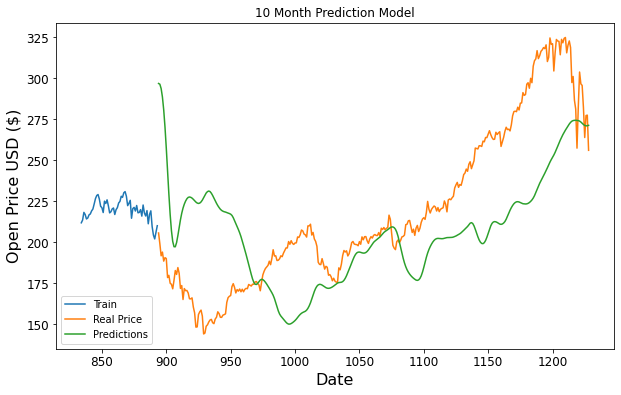

In [0]:
valid_10m['Predictions'] = predicted_stock_price_10m
# Visualize the data
plt.figure(figsize=(10,6))
plt.title('10 Month Prediction Model')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Open Price USD ($)', fontsize=16)
plt.plot(train_10m['Open'])
plt.plot(valid_10m[['Open', 'Predictions']])
plt.legend(['Train', 'Real Price', 'Predictions'], loc='lower left')
plt.show()

#Graph Results of Our Experiments and Conclusion

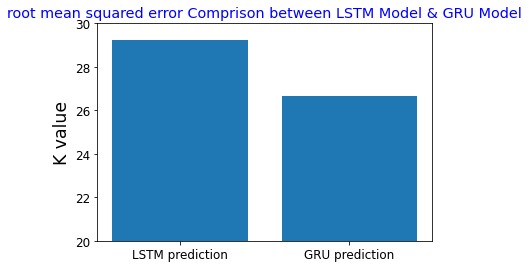

<Figure size 1440x720 with 0 Axes>

In [0]:
names = ['LSTM prediction', 'GRU prediction']
values = [rmse_LSTM, rmse_GRU]
plt.bar(names, values)
plt.rc('xtick', labelsize=14)
plt.ylim(20,30)
plt.ylabel("K value", fontsize = "xx-large")
plt.title("root mean squared error Comprison between LSTM Model & GRU Model", color = "blue", fontsize = "x-large")
plt.figure(figsize=(20,10))
plt.show()

Both GRU and LSTM funcion fairly well when using previous 60 days to predict the next day's open price. As we can see from previous plots, the trends of the predicted and real prices in both models are pretty much the same. Meaning both LSTM and GRU have the ability to remember sequenced data. A traditional feedforward neural networks would not have been able to forecast such good results. This is the true power of LSTM, GRU and RNNs. 

The key difference between a GRU and an LSTM is that a GRU has two gates (reset and update gates) whereas an LSTM has three gates (namely input, output and forget gates). GRU network is simpler and thus easier to modify, and takes less time to train. However, if sequence is large or accuracy is very critical, LSTM is better. 

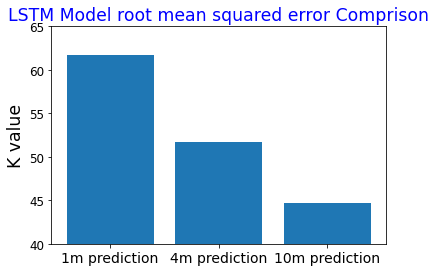

<Figure size 1440x720 with 0 Axes>

In [0]:
names = ['1m prediction', '4m prediction', '10m prediction']
values = [rmse_1m, rmse_4m, rmse_10m]
plt.bar(names, values)
plt.rc('xtick', labelsize=14)
plt.ylim(40,65)
plt.ylabel("K value", fontsize = "xx-large")
plt.title("LSTM Model root mean squared error Comprison", color = "blue", fontsize = "xx-large")
plt.figure(figsize=(20,10))
plt.show()

As we've learned during lectures the prediction for 1 month should have better accuracy than the predictions for 4 months and 10 months later, since the errors might accumulate.

But our practice data shows that the 1 month prediction has much higher deviation from the really price since we only use the previous 60 days for training. Its performance getting better when the model have more instances involved.

For future practice, it is reasonable to feed more previous data( e.g. 365 days, 5 years, or even more) into the model, therefore an error increasing curve is estimated might happen in the long period prediction.

# References:
https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944

https://stackoverflow.com/questions/52778922/stock-prediction-gru-model-predicting-same-given-values-instead-of-future-stoc

https://www.kaggle.com/charel/learn-by-example-rnn-lstm-gru-time-series

# Other tests

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
# fix random seed for reproducibility
seed = 32
np.random.seed(seed)
# load dataset
# dataset = np.array(load_ap_data())
# split into input (X) and output (Y) variables
# X = dataset[:,0:8]
# Y = dataset[:,8]
# create model
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=modelGRU, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

TypeError: ignored